Assignment 11: Adversarial Training
===================================


Microsoft Forms Document: https://forms.office.com/r/e3n9gYXsL5

In this assignment we will show that adversarial training provides stability against adversarial attacks for the MNIST dataset.
We will compare three different types of training procedures:

1. Train with only the original samples
2. Train with original samples and added random noise
3. Train with original samples and adversarial samples

Note that the results of this experiment might not translate well to other datasets.

Task 1: Dataset
---------------

We will make use of the default implementations of the MNIST dataset.
As usual, we will need the training and validation set splits of MNIST, including data loaders.
Select appropriate batch sizes for training and validation set.

In [2]:
import torch
import torchvision

# training set and data loader
train_set = torchvision.datasets.MNIST(root="./temp", download=True, train=True, transform=torchvision.transforms.ToTensor()) ###  transform 一定别忘了！！！
train_loader = torch.utils.data.DataLoader(train_set, 32, True)

# validation set and data loader
validation_set = torchvision.datasets.MNIST(root="./temp", download=True, train=False, transform=torchvision.transforms.ToTensor())
validation_loader = torch.utils.data.DataLoader(train_set, 100, False)

device = torch.device("cuda")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/train-images-idx3-ubyte.gz to ./temp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/train-labels-idx1-ubyte.gz to ./temp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/t10k-images-idx3-ubyte.gz to ./temp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./temp/MNIST/raw



Task 2: Classification Network
------------------------------
We use the same small-scale network as we have done in assignment 8. 

In [10]:
class Network (torch.nn.Module):
  def __init__(self, Q1, Q2, K, O):
    # call base class constrcutor
    super(Network,self).__init__()
    # define convolutional layers
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=5, stride=1, padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=5, stride=1, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2) ### 这里必须要写完整！！！
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(in_features=7*7*Q2, out_features=K, bias=True)
    self.fc2 = torch.nn.Linear(in_features=K, out_features=O, bias=False) ### 为什么不需要 bias???
  
  def forward(self,x):
    # compute first layer of convolution, pooling and activation
    a = self.act(self.pool(self.conv1(x)))
    # compute second layer of convolution, pooling and activation
    a = self.act(self.pool(self.conv2(a)))
    # get the deep features as the output of the first fully-connected layer
    deep_features = self.fc1(self.flatten(a))
    # get the logits as the output of the second fully-connected layer
    logits = self.fc2(deep_features)
    # return the logits
    return logits

# create network with 20 hidden neurons in FC layer
summary_network = Network(Q1=32,Q2=64,K=100,O=10).to(device) ### 这儿需要 to(device) 才不会报错
from torchsummary import summary
summary(summary_network,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         MaxPool2d-2           [-1, 32, 14, 14]               0
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
         MaxPool2d-5             [-1, 64, 7, 7]               0
              ReLU-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 100]         313,700
            Linear-9                   [-1, 10]           1,000
Total params: 366,796
Trainable params: 366,796
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 1.40
Estimated Total Size (MB): 1.86
-------------------------------------------

Task 3: Fast Gradient Sign
--------------------------

For adversarial training, we need to implement a function to generate an adversarial sample for a given input.
Here, we are implementing the Fast Gradient Sign method, which modifies the given input by adding a scaled version of the sign of the gradient:

$$\mathbf X_{\mathrm{FGS}} = \mathbf X + \alpha\,\mathrm{sign}(\nabla_{\mathbf X} \mathcal J)$$

Finally, the result needs to be clamped to be in range $[0,1]$.

Note that this function will be used with batches of samples.

In [11]:
def FGS(x, t, network, loss, alpha=0.3): # x.shape = (B,28,28)

  # tell autograd that we need the gradient for the input
  x.requires_grad_(True)
  # forward input
  z = network(x.to(device))
  # compute loss and gradient
  J = loss(z, t.to(device))
  J.backward()
  # get the gradient
  gradient = x.grad
  # create FGS adversarial sample
  adversarial_sample = x + alpha * torch.sign(gradient) 
  
  return torch.clamp(adversarial_sample, min=0, max=1) ### 加了是有可能超出[-1,1]的，所以要用到 torch.clamp(min,max)

Task 4: Random Noise
--------------------
For comparison, we want a function that produces noise similar to FGS, which we add to the image:

$$\mathbf X_{\mathrm{noise}} = \mathbf X + \alpha \{-1,1\} ^{D\times E}$$

Here, $-1$ and $1$ are sampled with the same probability, and independently for each pixel.

Again, we clamp the results to be in range $[0,1]$.

Note that this function will also be used with batches of samples.

In [43]:
def noise(x, alpha=0.3, **kwargs):
  # generate noise 
  N = (torch.rand(x.shape) - 0.5).sign() ### torch.rand( shape ) --> 每个格子产出 [0.1) 的浮点数 ### randint 呢？
  # Add noise and clamp
  noisy_sample = x + alpha*N
  return torch.clamp(noisy_sample, min=0, max=1)

Task 5: Training Loop
---------------------

Implement a training and validation loop that possibly includes training with adversarial or with noise samples.
This loop iterates over all training batches once, i.e., we implement one epoch of training here.

实现一个训练和验证循环，可能包括用对抗性样本或噪声样本进行训练。这个循环对所有的训练批次迭代一次，也就是说，我们在这里实现了一个训练的epoch。

<img src="https://s2.loli.net/2022/06/10/vF6MePxAqLmK45f.png" width=20%/>


In [13]:
def training_loop(network, loss, optimizer, add_additional_samples = None, alpha=0.3):
  for x,t in train_loader:
    optimizer.zero_grad()
    # compute output for current batch
    z = network(x.to(device))
    # compute loss
    J = loss(z,t.to(device))
    # compute gradient
    J.backward()
    optimizer.step()
    
    if add_additional_samples is not None:
      optimizer.zero_grad() ### 直接清除梯度，重新更新一次，最简单
      # compute modified samples for batch
      if add_additional_samples == "FGS":
        # create FGS adversarial samples
        x_hat = FGS(x, t, network, loss, alpha)
      else:
        # create noisy samples
        x_hat = noise(x, alpha)

      # compute output for modified samples
      z_hat = network(x_hat.to(device))
      # compute loss on modified samples
      J = loss(z_hat,t.to(device))
      # compute gradient
      J.backward()  
      optimizer.step()
    

Task 6: Validation Loop
-----------------------

We need to compute both the classification accuracy and the adversarial stability for the validation set.
For each batch, first we select the correctly classified images.
For these, we generate FGS adversarial samples.
Finally, we test whether these adversarial samples are classified as the original classes.

Compute classification accuracy and adversarial accuracy on the whole test set.
Think about how to normalize the adversarial accuracy.

我们需要计算验证集的分类精度和对抗性稳定性。对于每个批次，首先我们选择正确分类的图像。对于这些，我们生成FGS对抗性样本。最后，我们测试这些对抗性样本是否被分类为原始类别。

计算整个测试集的分类准确性和对抗性准确性。思考如何将对抗性准确性归一化。

In [16]:
def validation_loop(network, loss, alpha=0.3):
  total, correct_clean_count, correct_adversarial_count = 0,0,0

  # iterate over validation set samples
  for x,t in validation_loader:
    total += x.shape[0]
    with torch.no_grad():
      # classify original samples
      z = network(x.to(device))

      # compute classification accuracy on original samples
      correct_idx = z.cpu().argmax(dim=1) == t
      correct_clean_count += torch.sum(correct_idx).item() # 好像必须加 item, 不然 type 是tensor

    # select the correctly classified samples
    x_correct = x[correct_idx]
    t_correct = t[correct_idx]
    # create adversarial samples using FGS
    x_FGS = FGS(x_correct, t_correct, network, loss, alpha)

    # check how many are correctly classified
    with torch.no_grad():
      # classify adversarial samples
      z_FGS = network(x_FGS.to(device))

      # compute classification accuracy on adversarial samples
      correct_idx = z_FGS.cpu().argmax(dim=1) == t_correct
      correct_adversarial_count += torch.sum(correct_idx).item()


  # compute clean and adversarial accuracy and return them
  clean_accuracy = correct_clean_count / total
  adversarial_accuracy = correct_adversarial_count / correct_clean_count
  return clean_accuracy, adversarial_accuracy

Task 7: Training of Three Networks
----------------------------------

Instantiate three different but identical networks.
Instantiate according optimizers that train these networks.
Train these networks for 10 epochs.
The first network will be trained on clean samples only.
The second network will be trained using adversarial samples.
The third network will be trained with noise samples.

Evaluate all three networks on the validation set, and record clean and adversarial classification accuracies.

Note that the training time is extended as compared to a normal training since the creation of adversarial samples requires time.

实例化三个不同但相同的网络。根据训练这些网络的优化器来实例化。训练这些网络10个历时。第一个网络将只在干净的样本上训练。第二个网络将使用对抗性样本进行训练。第三个网络将用噪声样本进行训练。

在验证集上评估所有三个网络，并记录清洁和对抗性分类的准确率。

请注意，与正常的训练相比，训练时间会延长，因为创建对抗性样本需要时间。

In [19]:
additionals = (None, "FGS", "noise")

# define one network for each training procedure
networks = {k : Network(Q1=32,Q2=64,K=100,O=10).to(device) for k in additionals } ### 创建 dict 来索引不同的网络
# define optimizer
optimizers = {k : torch.optim.SGD(params = networks[k].parameters(),lr=0.01,momentum=0.9) for k in additionals}

# define loss function
loss = torch.nn.CrossEntropyLoss()

# store accuracies on clean and adversarial samples for the three cases
clean_accuracies = {k : [] for k in additionals}
adversarial_accuracies = { k : [] for k in additionals }

# iterate over 10 epochs (or more)
for epoch in range(10):
  for k in additionals:
    # perform training loop
    training_loop(networks[k], loss, optimizers[k], add_additional_samples = k, alpha=0.3)
    # compute and store validation set accuracies
    c_acc, a_acc = validation_loop(networks[k], loss, 0.3)
    clean_accuracies[k].append(c_acc)
    adversarial_accuracies[k].append(a_acc)
    print(f"\rEpoch {epoch} | {k} | clean_acc: {c_acc :1.5f}; adversarial_acc: {a_acc :1.5f}")
  print("\n")

Epoch 0 | None | clean_acc: 0.98273; adversarial_acc: 0.06404
Epoch 0 | FGS | clean_acc: 0.97978; adversarial_acc: 0.85248
Epoch 0 | noise | clean_acc: 0.98647; adversarial_acc: 0.14920


Epoch 1 | None | clean_acc: 0.98908; adversarial_acc: 0.03188
Epoch 1 | FGS | clean_acc: 0.98753; adversarial_acc: 0.88660
Epoch 1 | noise | clean_acc: 0.99123; adversarial_acc: 0.23652


Epoch 2 | None | clean_acc: 0.98672; adversarial_acc: 0.13183
Epoch 2 | FGS | clean_acc: 0.99072; adversarial_acc: 0.91718
Epoch 2 | noise | clean_acc: 0.99460; adversarial_acc: 0.31287


Epoch 3 | None | clean_acc: 0.99222; adversarial_acc: 0.12410
Epoch 3 | FGS | clean_acc: 0.99275; adversarial_acc: 0.97332
Epoch 3 | noise | clean_acc: 0.99478; adversarial_acc: 0.25768


Epoch 4 | None | clean_acc: 0.99558; adversarial_acc: 0.14271
Epoch 4 | FGS | clean_acc: 0.99213; adversarial_acc: 0.92441
Epoch 4 | noise | clean_acc: 0.99463; adversarial_acc: 0.33726


Epoch 5 | None | clean_acc: 0.99650; adversarial_acc: 0.1454

Task 8: Plotting of Accuracies
------------------------------

Plot the different clean accuracies and adversarial accuracies over the training epochs.

Text(0.5, 0, 'Epoch')

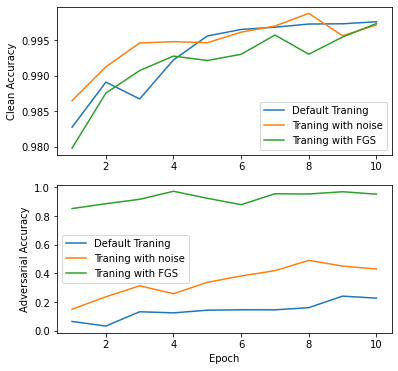

In [20]:
from matplotlib import pyplot

pyplot.figure(figsize=(6,6))

# plot clean accuracies
XX = list(range(1,11))
pyplot.subplot(211)
pyplot.plot(XX, clean_accuracies[None], label="Default Traning")
pyplot.plot(XX, clean_accuracies["noise"], label="Traning with noise")
pyplot.plot(XX, clean_accuracies["FGS"], label="Traning with FGS")
pyplot.legend()
pyplot.ylabel("Clean Accuracy")


# plot adversarial accuracies
pyplot.subplot(212)
pyplot.plot(XX, adversarial_accuracies[None], label="Default Traning")
pyplot.plot(XX, adversarial_accuracies["noise"], label="Traning with noise")
pyplot.plot(XX, adversarial_accuracies["FGS"], label="Traning with FGS")
pyplot.legend()
pyplot.ylabel("Adversarial Accuracy")

pyplot.xlabel("Epoch")